#### Notes from the Readme File

A: The usage of the data set is unrestricted. But you should provide the link to our original download site, acknowledge the NIH Clinical Center and provide a citation to our CVPR 2017 paper

A: ‘No finding’ means the 14 listed disease patterns are not found in the image. 

https://www.kaggle.com/nih-chest-xrays/data

Citations
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

NIH News release: NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community

Original source files and documents: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

### Context Behind Dataset for Final Writeup:

Dataset was gathered by the NIH and contains over 100,000 anonymized chest x-ray images from more than 30,000 patients.  

# Goal
The goal is to use a simple model to classify x-ray images in Keras, the notebook how to use the ```flow_from_dataframe``` to deal with messier datasets

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('.', 'data', 'images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)


#all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
21359,00005695_004.png,No Finding,4,5695,20,F,AP,2500,2048,0.171,0.171,NaN,.\data\images\00005695_004.png
50951,00012880_013.png,No Finding,13,12880,65,M,PA,2500,2048,0.168,0.168,NaN,.\data\images\00012880_013.png
99583,00026367_000.png,Nodule,0,26367,58,F,PA,2992,2991,0.143,0.143,NaN,.\data\images\00026367_000.png


# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

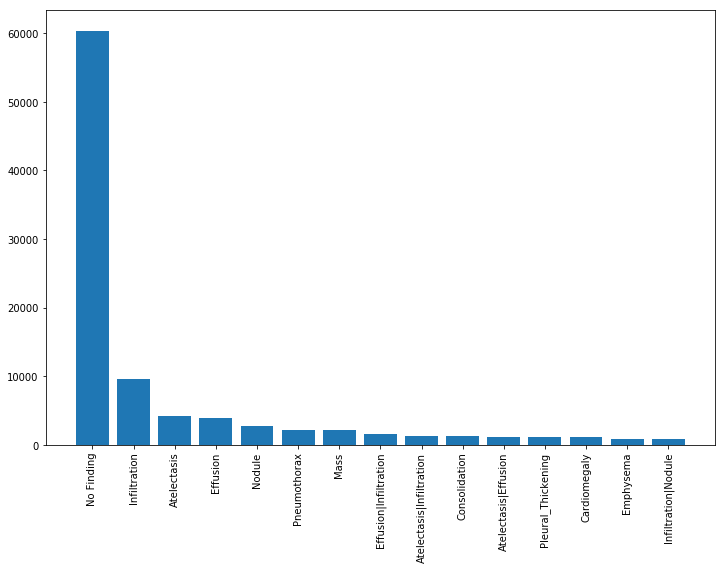

In [3]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [4]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
29965,00007804_000.png,Effusion,0,7804,50,F,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67062,00016572_002.png,Pneumothorax,2,16572,45,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
79079,00019406_009.png,Emphysema,9,19406,55,M,AP,3056,2544,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [6]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


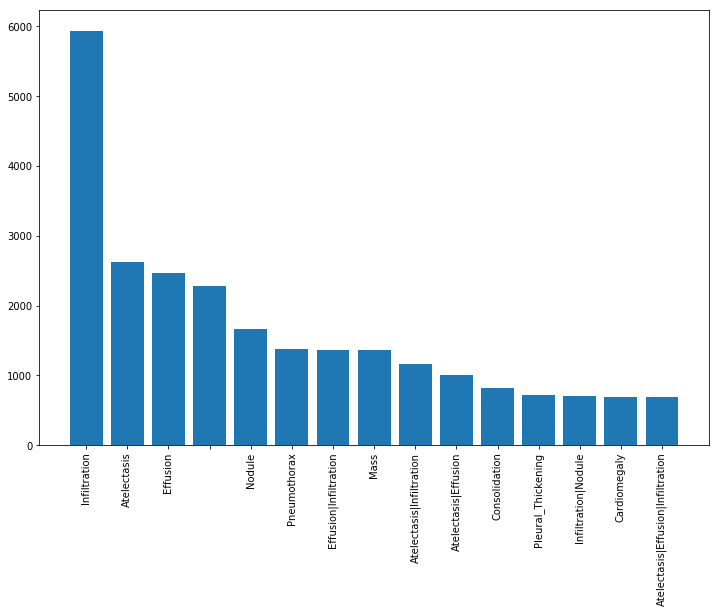

In [7]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

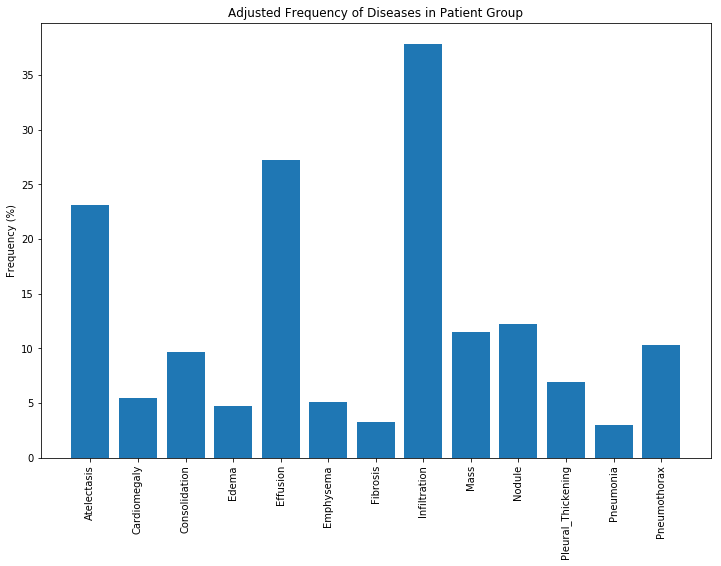

In [8]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [9]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [10]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


# Create Data Generators
Here we make the data generators for loading and randomly transforming images

In [15]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

C:\Users\brent\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\brent\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [17]:
train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))

Found 28240 validated image filenames belonging to 13 classes.
Found 9411 validated image filenames belonging to 13 classes.
Found 9411 validated image filenames belonging to 13 classes.


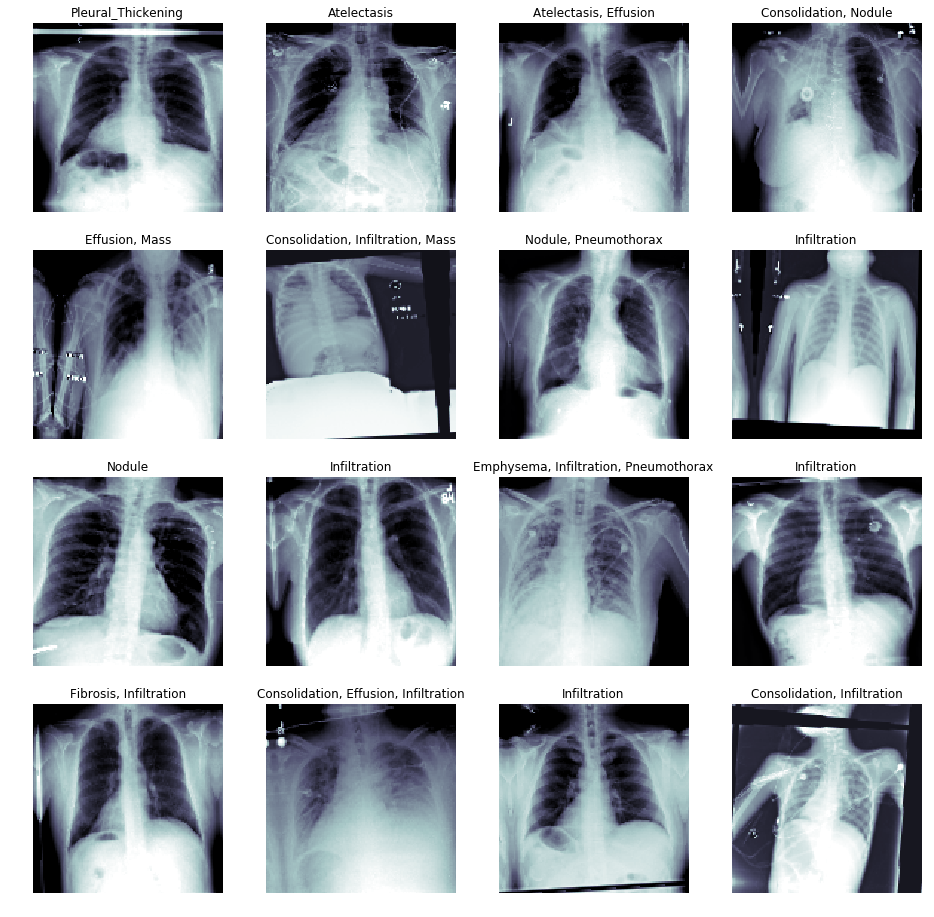

In [18]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Create a simple model
Here we make a simple model to train using MobileNet as a base and then adding a GAP layer (Flatten could also be added), dropout, and a fully-connected layer to calculate specific features

In [32]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 13)                6669      
Total params: 3,759,757
Trainable params: 3,737,869
Non-trainable params: 21,888
_____________________________________________________________

In [20]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]

# First Round
Here we do a first round of training to get a few initial low hanging fruit results

In [33]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

Epoch 1/1
100/100 [==============================] - 34s 345ms/step - loss: 0.4608 - binary_accuracy: 0.8417 - mean_absolute_error: 0.2090 - val_loss: 0.8255 - val_binary_accuracy: 0.8706 - val_mean_absolute_error: 0.1499

Epoch 00001: val_loss did not improve from 0.34069


# Check Output
Here we see how many positive examples we have of each category

In [37]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 25.88%
Cardiomegaly: 6.05%
Consolidation: 9.96%
Edema: 4.79%
Effusion: 27.05%
Emphysema: 5.76%
Fibrosis: 3.22%
Infiltration: 38.18%
Mass: 12.89%
Nodule: 12.11%
Pleural_Thickening: 7.52%
Pneumonia: 4.39%
Pneumothorax: 10.55%


In [38]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 2s 2ms/step


# ROC Curves
While a very oversimplified metric, we can show the ROC curve for each metric

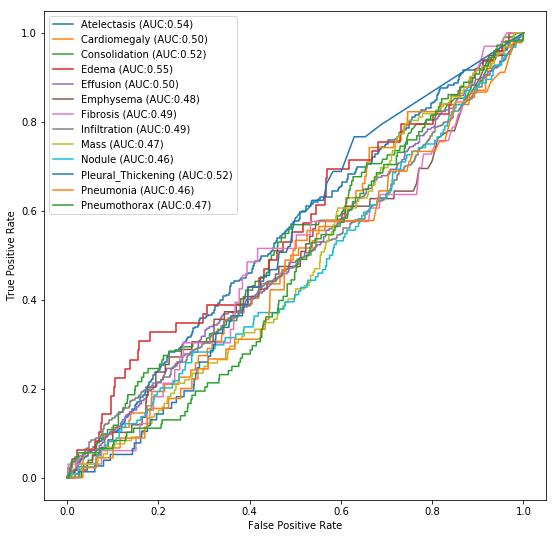

In [39]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

### Optimizer Selection

In [42]:
optimizers_list = [('sgd',optimizers.SGD( lr=.1) ),
                   ('sgd_momentum',optimizers.SGD(lr=.1, momentum=.9) ),
                   ('adagrad',optimizers.Adagrad()),
                   ('adadelta',optimizers.Adadelta()),
                   ('adam', optimizers.Adam()) 
                  ]

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [early]

In [ ]:
plt.figure(figsize=(20,5))
for optimizer in optimizers_list:
    multi_disease_model.compile(optimizer = optimizer[1], loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
    
    history = multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=1000,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 50, 
                                  callbacks = callbacks_list)
      
    
    plt.plot(history.history['val_loss'])
    
plt.legend([x[0] for x in optimizers_list], loc='upper right')
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('optimizer_selection.png', bbox_inches='tight')

Epoch 1/50
1000/1000 [==============================] - 307s 307ms/step - loss: 0.3181 - binary_accuracy: 0.8738 - mean_absolute_error: 0.1904 - val_loss: 0.3175 - val_binary_accuracy: 0.8745 - val_mean_absolute_error: 0.1910
Epoch 2/50
1000/1000 [==============================] - 305s 305ms/step - loss: 0.3149 - binary_accuracy: 0.8750 - mean_absolute_error: 0.1885 - val_loss: 0.3163 - val_binary_accuracy: 0.8754 - val_mean_absolute_error: 0.1911
Epoch 3/50
1000/1000 [==============================] - 305s 305ms/step - loss: 0.3149 - binary_accuracy: 0.8745 - mean_absolute_error: 0.1888 - val_loss: 0.3159 - val_binary_accuracy: 0.8758 - val_mean_absolute_error: 0.1906
Epoch 4/50
1000/1000 [==============================] - 305s 305ms/step - loss: 0.3139 - binary_accuracy: 0.8752 - mean_absolute_error: 0.1882 - val_loss: 0.3148 - val_binary_accuracy: 0.8758 - val_mean_absolute_error: 0.1868
Epoch 5/50
1000/1000 [==============================] - 305s 305ms/step - loss: 0.3136 - binary_

1000/1000 [==============================] - 305s 305ms/step - loss: 0.3055 - binary_accuracy: 0.8784 - mean_absolute_error: 0.1833 - val_loss: 0.3092 - val_binary_accuracy: 0.8786 - val_mean_absolute_error: 0.1832
Epoch 38/50
1000/1000 [==============================] - 305s 305ms/step - loss: 0.3052 - binary_accuracy: 0.8780 - mean_absolute_error: 0.1832 - val_loss: 0.3102 - val_binary_accuracy: 0.8791 - val_mean_absolute_error: 0.1823
Epoch 39/50
1000/1000 [==============================] - 304s 304ms/step - loss: 0.3053 - binary_accuracy: 0.8784 - mean_absolute_error: 0.1832 - val_loss: 0.3101 - val_binary_accuracy: 0.8787 - val_mean_absolute_error: 0.1832
Epoch 40/50
1000/1000 [==============================] - 305s 305ms/step - loss: 0.3057 - binary_accuracy: 0.8779 - mean_absolute_error: 0.1834 - val_loss: 0.3094 - val_binary_accuracy: 0.8784 - val_mean_absolute_error: 0.1846
Epoch 41/50
1000/1000 [==============================] - 305s 305ms/step - loss: 0.3048 - binary_accurac

# Continued Training
Now we do a much longer training process to see how the results improve

In [25]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 100, 
                                  callbacks = callbacks_list)

Epoch 1/100
100/100 [==============================] - 35s 350ms/step - loss: 0.3855 - binary_accuracy: 0.8575 - mean_absolute_error: 0.2060 - val_loss: 0.3920 - val_binary_accuracy: 0.8596 - val_mean_absolute_error: 0.1952

Epoch 00001: val_loss improved from 0.86162 to 0.39204, saving model to xray_class_weights.best.hdf5
Epoch 2/100
100/100 [==============================] - 35s 346ms/step - loss: 0.3570 - binary_accuracy: 0.8636 - mean_absolute_error: 0.2046 - val_loss: 0.3543 - val_binary_accuracy: 0.8705 - val_mean_absolute_error: 0.1933

Epoch 00002: val_loss improved from 0.39204 to 0.35434, saving model to xray_class_weights.best.hdf5
Epoch 3/100
100/100 [==============================] - 34s 340ms/step - loss: 0.3561 - binary_accuracy: 0.8614 - mean_absolute_error: 0.2071 - val_loss: 0.3507 - val_binary_accuracy: 0.8715 - val_mean_absolute_error: 0.1852

Epoch 00003: val_loss improved from 0.35434 to 0.35068, saving model to xray_class_weights.best.hdf5
Epoch 4/100
100/100 [=

In [26]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [27]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 1s 497us/step


In [28]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 25.88%, PDx: 17.21%
Cardiomegaly: Dx: 6.05%, PDx: 5.13%
Consolidation: Dx: 9.96%, PDx: 10.09%
Edema: Dx: 4.79%, PDx: 4.46%
Effusion: Dx: 27.05%, PDx: 21.82%
Emphysema: Dx: 5.76%, PDx: 5.79%
Fibrosis: Dx: 3.22%, PDx: 3.88%
Infiltration: Dx: 38.18%, PDx: 38.75%
Mass: Dx: 12.89%, PDx: 13.24%
Nodule: Dx: 12.11%, PDx: 16.45%
Pleural_Thickening: Dx: 7.52%, PDx: 7.55%
Pneumonia: Dx: 4.39%, PDx: 3.83%
Pneumothorax: Dx: 10.55%, PDx: 14.31%


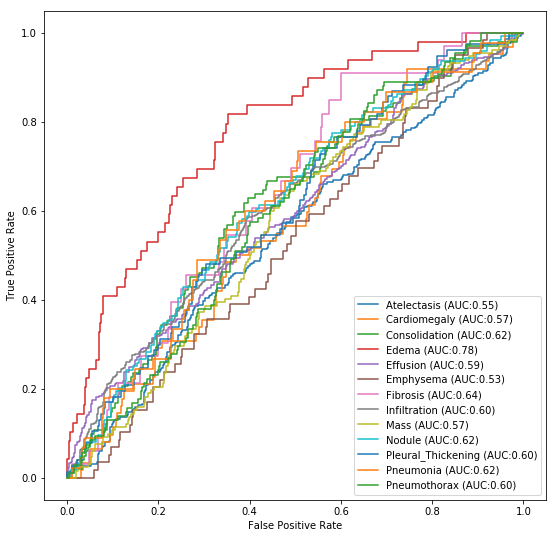

In [29]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

# Show a few images and associated predictions

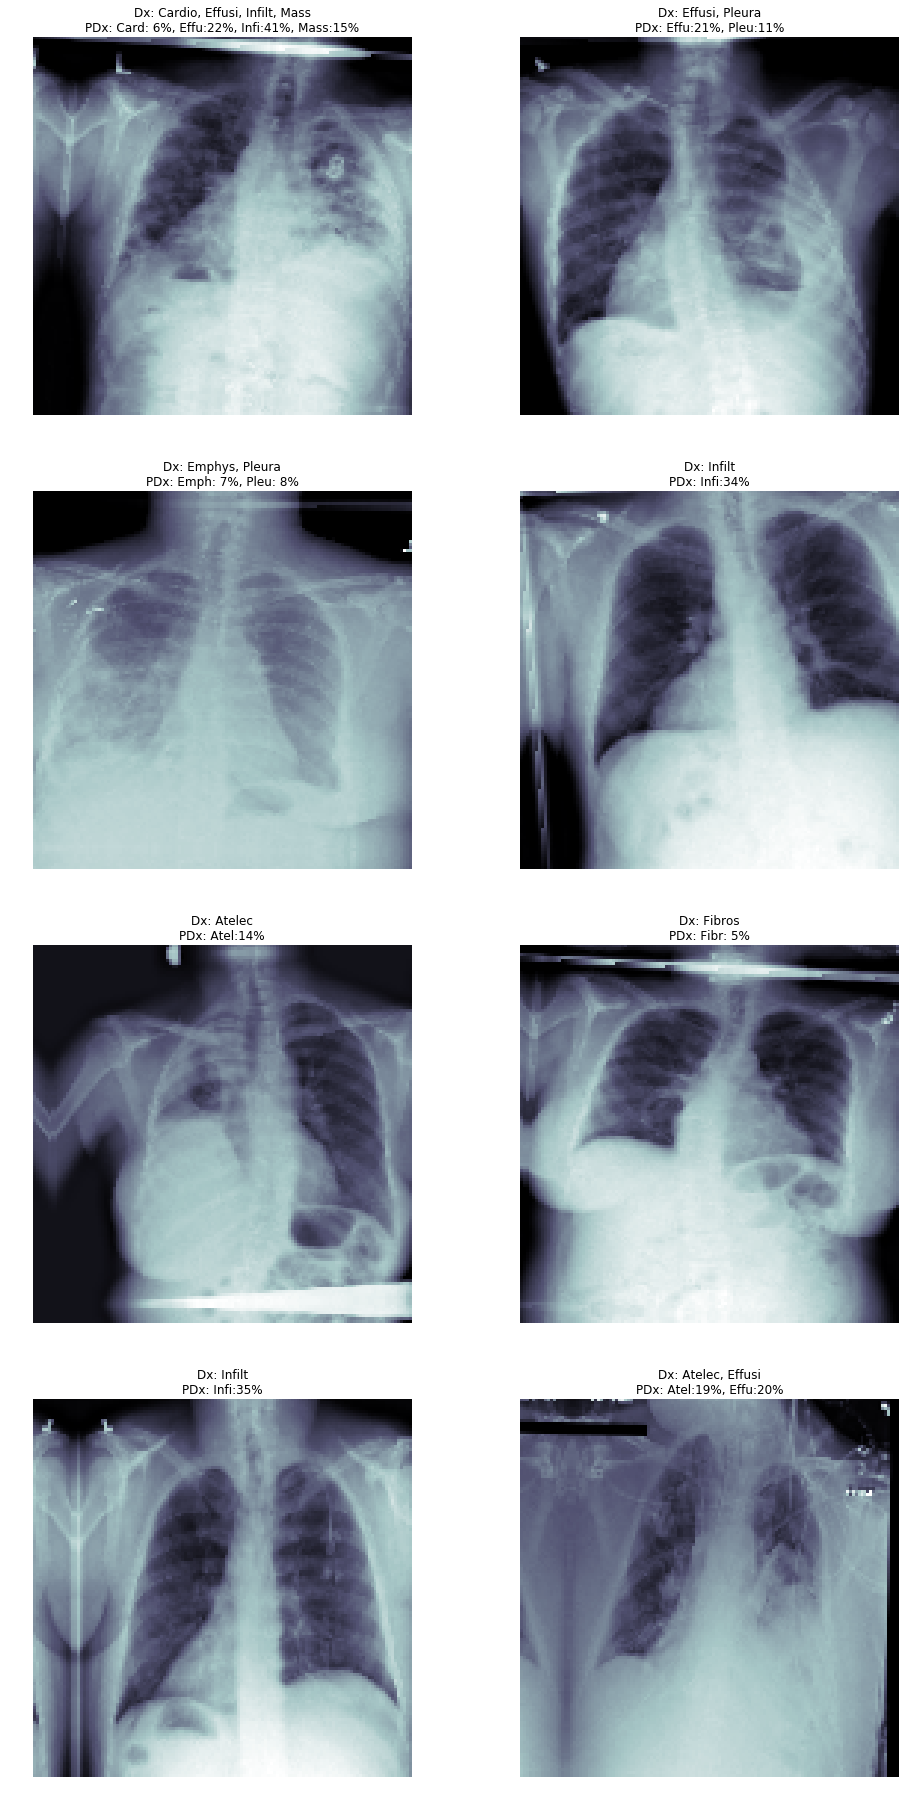

In [30]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')